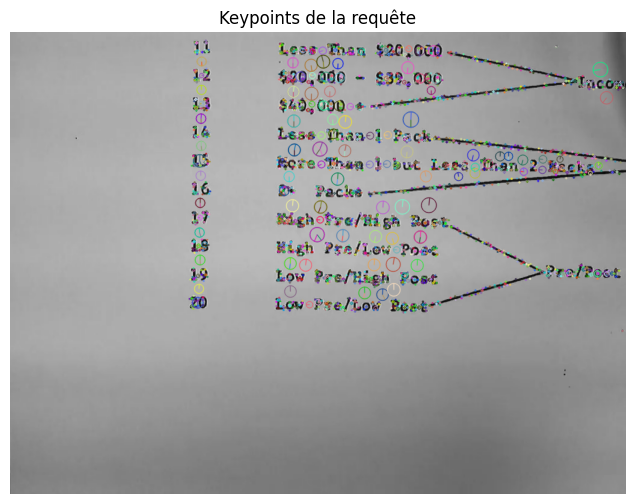

📄 Document reconnu: 0055.jpg


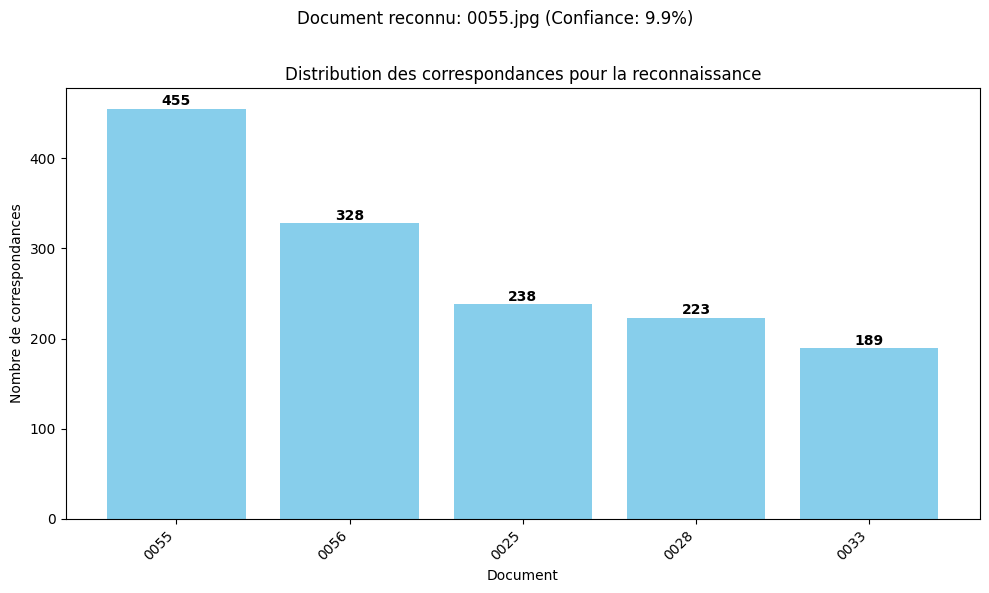

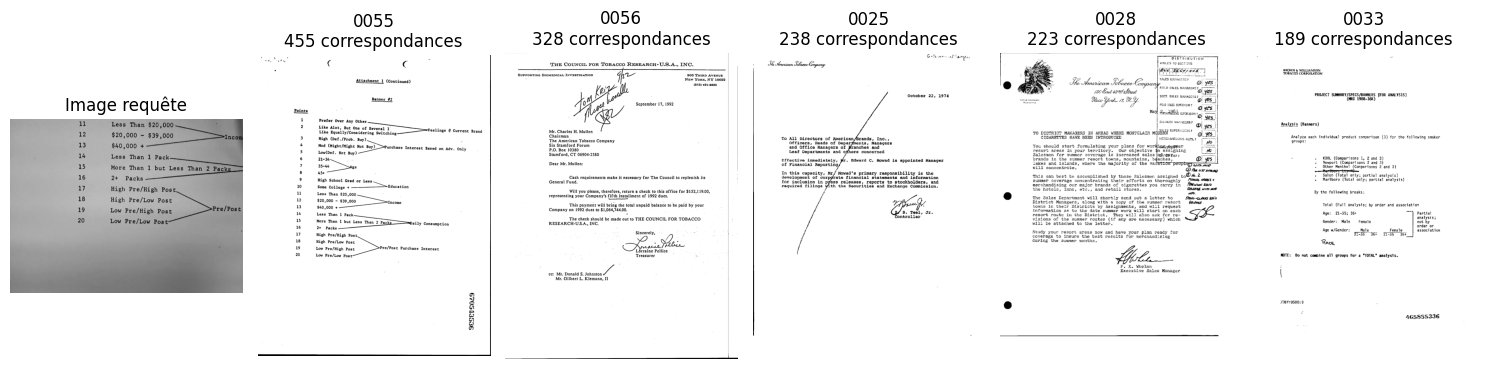

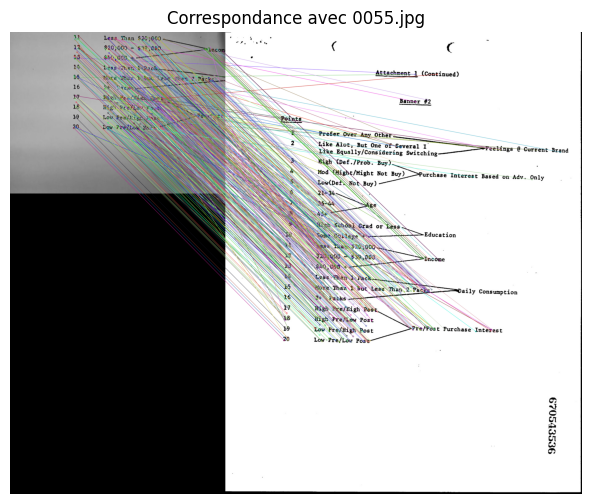

In [ ]:
import cv2
import numpy as np
import os
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

# --- SIFT extractor ---
sift = cv2.SIFT_create()

def extract_sift_features(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return image, keypoints, descriptors

# --- Chargement dataset ---
def load_dataset_features(folder_path):
    features = {}
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
            path = os.path.join(folder_path, filename)
            img, kp, des = extract_sift_features(path)
            features[filename] = {'image': img, 'keypoints': kp, 'descriptors': des}
    return features

# --- Extraire une frame depuis une vidéo ---
def extract_frame_from_video(video_path, frame_index=30):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
    ret, frame = cap.read()
    cap.release()
    if ret:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        return gray
    return None

# --- Affichage keypoints ---
def show_keypoints(image, keypoints, title="Keypoints"):
    img_kp = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=(8,6))
    plt.title(title)
    plt.imshow(img_kp, cmap='gray')
    plt.axis('off')
    plt.show()

# --- Matcher avec FLANN ---
def match_query_to_dataset(query_des, dataset_features):
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    match_counts = {}
    for name, data in dataset_features.items():
        if data['descriptors'] is not None and len(data['descriptors']) >= 2:
            # On cherche pour chaque descripteur de l'image requête les 2 plus proches voisins dans les descripteurs de l'image du dataset.
            matches = flann.knnMatch(query_des, data['descriptors'], k=2)
            # Cela permet d'éliminer les fausses correspondances. On garde un match seulement si
            #  le premier voisin est beaucoup plus proche que le second (rapport des distances < 0.7).
            good = [m for m, n in matches if m.distance < 0.7 * n.distance]
            match_counts[name] = len(good)
    return match_counts

# --- Visualisation des matches entre la requête et la meilleure image ---
def show_best_match(query_img, query_kp, query_des, dataset_features, best_match_name):
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    best_data = dataset_features[best_match_name]
    matches = flann.knnMatch(query_des, best_data['descriptors'], k=2)
    good = [m for m, n in matches if m.distance < 0.7 * n.distance]

    match_img = cv2.drawMatchesKnn(query_img, query_kp,
                                    best_data['image'], best_data['keypoints'],
                                    [[m] for m in good], None, flags=2)

    plt.figure(figsize=(12, 6))
    plt.title(f"Correspondance avec {best_match_name}")
    plt.imshow(match_img)
    plt.axis('off')
    plt.show()

def find_best_match(query_img, query_kp, query_des, dataset_features):
    match_counts = Counter()
    
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    for img_name, data in dataset_features.items():
        if data['descriptors'] is not None and len(data['descriptors']) >= 2:
            matches = flann.knnMatch(query_des, data['descriptors'], k=2)
            good = [m for m, n in matches if m.distance < 0.7 * n.distance]
            match_counts[img_name] = len(good)
    
    # Retourne le nom de l'image avec le plus grand nombre de correspondances
    if match_counts:
        return match_counts.most_common(1)[0][0], match_counts
    return None, match_counts

# --- Nouvelle fonction: Visualisation des résultats de vote ---
def visualize_votes(match_counts, title="Distribution des votes"):
    # Convertir en Counter si ce n'est pas déjà le cas
    if not isinstance(match_counts, Counter):
        match_counts = Counter(match_counts)
        
    # Récupérer les 5 meilleurs résultats (ou moins s'il y en a moins)
    top_matches = match_counts.most_common(min(5, len(match_counts)))
    
    if not top_matches:
        print("Aucun vote à afficher.")
        return
    
    # Préparer les données pour le graphique
    labels = [os.path.splitext(name)[0] for name, _ in top_matches]  # Enlever l'extension
    counts = [count for _, count in top_matches]
    
    # Créer le graphique à barres
    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(len(labels)), counts, color='skyblue')
    plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
    
    # Ajouter le nombre de votes au-dessus de chaque barre
    for i, (bar, count) in enumerate(zip(bars, counts)):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'{count}', ha='center', va='bottom', fontweight='bold')
    
    plt.title(title)
    plt.xlabel('Document')
    plt.ylabel('Nombre de correspondances')
    
    # Calculer le score de confiance
    total_votes = sum(match_counts.values())
    if total_votes > 0 and top_matches:
        confidence = (top_matches[0][1] / total_votes) * 100
        plt.suptitle(f"Document reconnu: {top_matches[0][0]} (Confiance: {confidence:.1f}%)")
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Ajustement pour le suptitle
    plt.show()

# --- Fonction pour visualiser le top N documents avec leurs scores ---
def show_top_matches_grid(query_img, query_kp, query_des, dataset_features, match_counts, top_n=9):
    top_matches = Counter(match_counts).most_common(top_n)
    
    if not top_matches:
        print("Aucun match à afficher.")
        return
    
    # Configuration de la grille d'affichage
    fig, axes = plt.subplots(1, top_n+1, figsize=(15, 5))
    
    # Afficher l'image requête
    axes[0].imshow(query_img, cmap='gray')
    axes[0].set_title("Image requête")
    axes[0].axis('off')
    
    # Afficher les top N images correspondantes
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    for i, (img_name, count) in enumerate(top_matches, 1):
        if i <= top_n:
            data = dataset_features[img_name]
            matches = flann.knnMatch(query_des, data['descriptors'], k=2)
            good = [m for m, n in matches if m.distance < 0.7 * n.distance]
            
            axes[i].imshow(data['image'], cmap='gray')
            axes[i].set_title(f"{os.path.splitext(img_name)[0]}\n{count} correspondances")
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# --- Démo d'exécution ---
dataset_folder = "images"
video_path = "requetes/55-BL.mp4"

# 1. Indexer les images
dataset_features = load_dataset_features(dataset_folder)

# 2. Extraire une frame et les features
query_img = extract_frame_from_video(video_path, frame_index=1)  # Première frame
query_kp, query_des = sift.detectAndCompute(query_img, None)

# 3. Afficher les keypoints de la requête
show_keypoints(query_img, query_kp, title="Keypoints de la requête")

# 4. Comparaison avec le dataset et récupération des votes
best_match, match_counts = find_best_match(query_img, query_kp, query_des, dataset_features)
print("📄 Document reconnu:", best_match)

# 5. Visualiser les résultats de vote
visualize_votes(match_counts, "Distribution des correspondances pour la reconnaissance")

# 6. Afficher la grille des meilleures correspondances
show_top_matches_grid(query_img, query_kp, query_des, dataset_features, match_counts, top_n=5)

# 7. Afficher les correspondances détaillées pour la meilleure image
show_best_match(query_img, query_kp, query_des, dataset_features, best_match)

Chargement des features du dataset...
Dataset chargé: 45 images
Construction de la table de hachage...
Table de hachage créée avec 10007 buckets uniques
Extraction de la frame depuis la vidéo...
Extraction des features SIFT standards...
Requête: 2667 keypoints extraits
Extraction des features denses sur une grille...
Features denses extraites: 3588 points
Total de features combinées: 6255


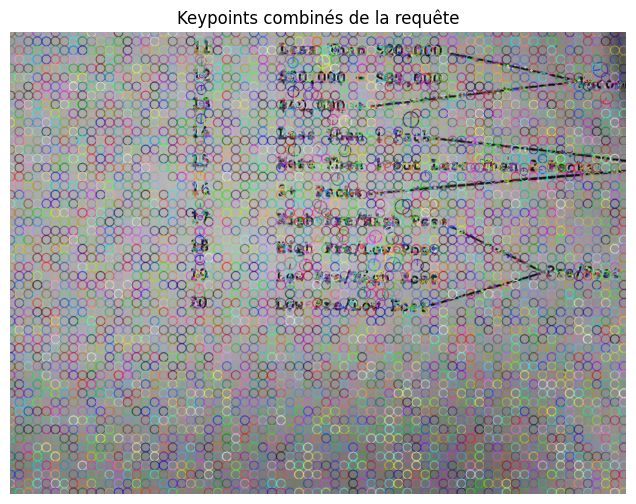

Recherche dans la table de hachage...
📄 Document reconnu: 0016.jpg avec 10 votes


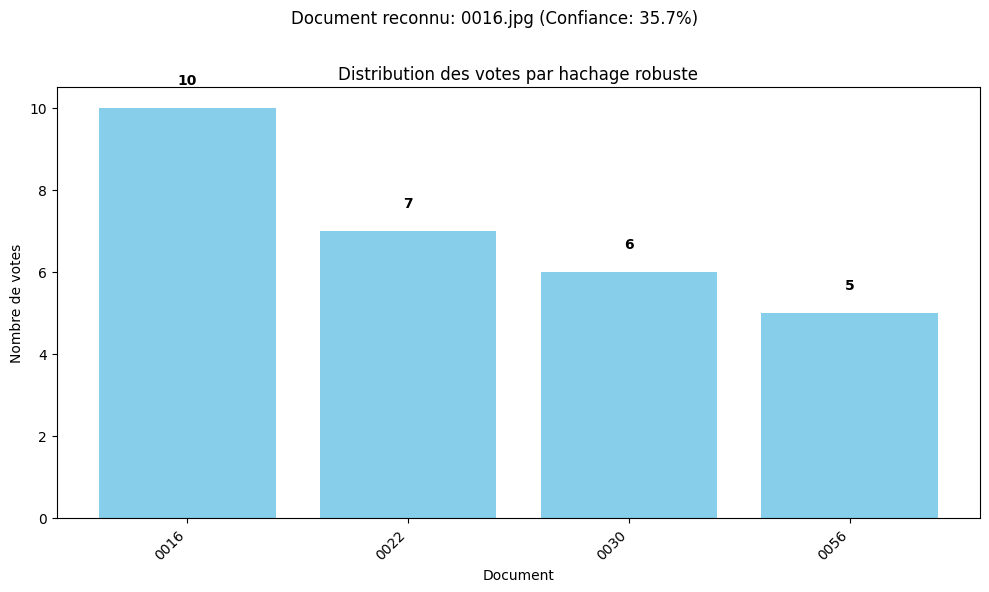

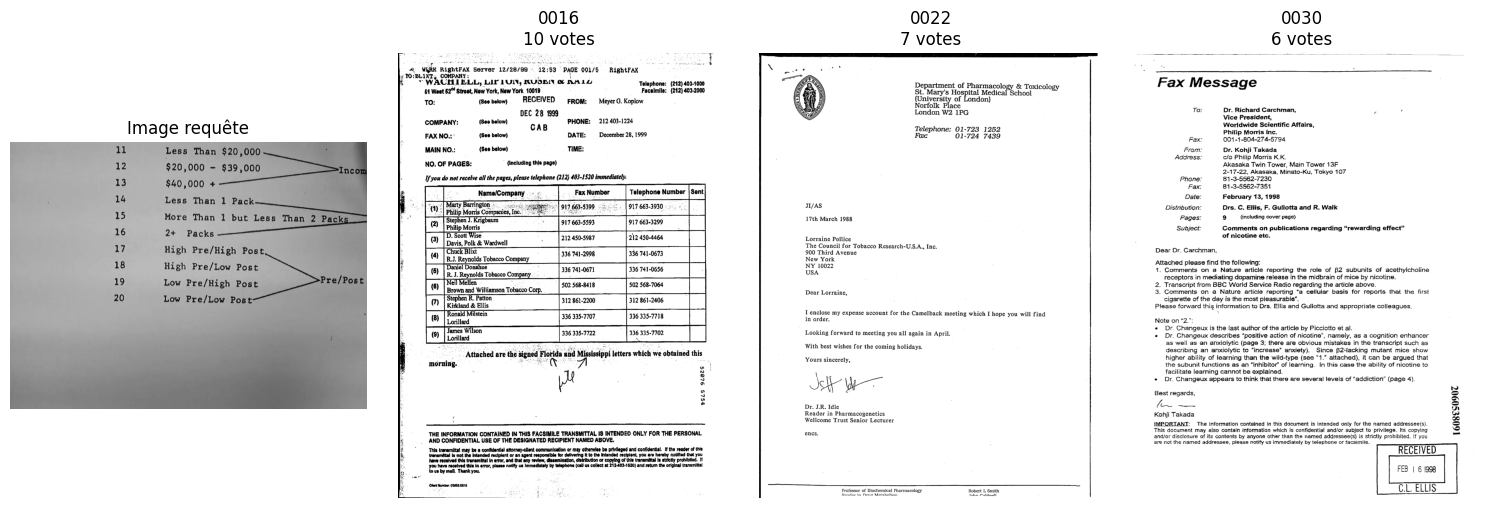

Affichage des 10 correspondances...


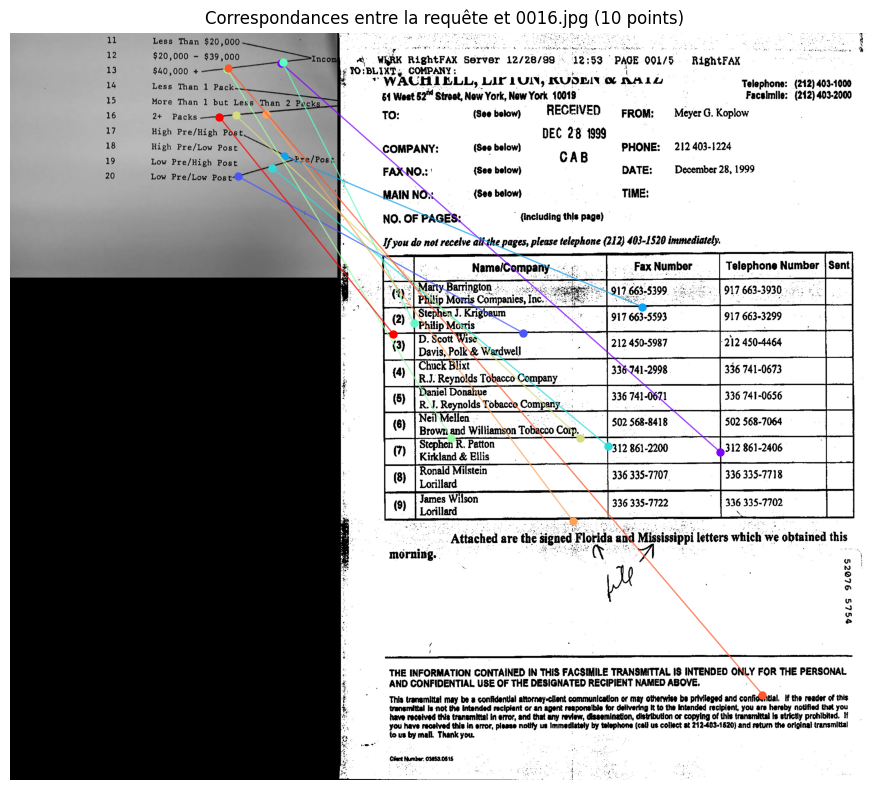

In [8]:
import cv2
import numpy as np
import os
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

# --- SIFT extractor ---
sift = cv2.SIFT_create()

# --- Fonction de hachage robuste ---
def robust_hash(descriptor, q=31, H_size=10007):
    """
    Crée un hash robuste à partir d'un descripteur SIFT
    - Quantification des valeurs
    - Utilisation d'un polynôme de hachage
    """
    quantized = np.round(descriptor).astype(int)
    return int(np.sum([v * (q ** (i % 4)) for i, v in enumerate(quantized)]) % H_size)

# --- Création de la table de hachage ---
def create_hash_table(dataset_features, q=31, H_size=10007):
    """
    Crée une table de hachage pour l'ensemble du dataset
    """
    hash_table = defaultdict(list)
    for img_name, data in dataset_features.items():
        keypoints = data['keypoints']
        descriptors = data['descriptors']
        if descriptors is not None:
            for i, desc in enumerate(descriptors):
                h = robust_hash(desc, q=q, H_size=H_size)
                hash_table[h].append((img_name, keypoints[i], desc))
    print(f"Table de hachage créée avec {len(hash_table)} buckets uniques")
    return hash_table

# --- Extraction dense de features sur une grille ---
def extract_dense_features(image, step_size=20):
    """
    Extrait des caractéristiques SIFT sur une grille régulière couvrant toute l'image
    """
    height, width = image.shape
    
    # Créer une grille dense de points
    grid_points = []
    for y in range(0, height, step_size):
        for x in range(0, width, step_size):
            grid_points.append(cv2.KeyPoint(x, y, step_size))
    
    # Calculer les descripteurs SIFT pour tous les points de la grille
    _, descriptors = sift.compute(image, grid_points)
    
    print(f"Features denses extraites: {len(grid_points)} points")
    return grid_points, descriptors

# --- Recherche améliorée par hachage ---
def query_with_hash_improved(query_kp, query_des, hash_table, q=31, H_size=10007, threshold=150, min_votes=10):
    """
    Recherche les correspondances en utilisant la table de hachage avec vérification spatiale
    Retourne les votes pour chaque image et les correspondances de points
    """
    vote_counter = Counter()
    matches_per_image = defaultdict(list)
    
    # Pour chaque descripteur de la requête
    for i, desc in enumerate(query_des):
        h = robust_hash(desc, q=q, H_size=H_size)
        candidates = hash_table.get(h, [])
        
        for img_name, keypoint, ref_desc in candidates:
            # Calculer la distance euclidienne entre les descripteurs
            distance = np.linalg.norm(desc - ref_desc)
            
            # Si la distance est inférieure au seuil, voter pour cette image
            if distance < threshold:
                vote_counter[img_name] += 1
                matches_per_image[img_name].append((query_kp[i], keypoint, distance))
    
    # Filtrer les correspondances pour chaque image
    for img_name in list(matches_per_image.keys()):
        # Trier les correspondances par distance (du plus proche au plus éloigné)
        matches_per_image[img_name].sort(key=lambda x: x[2])
        
        # Garder uniquement les meilleures correspondances (pour réduire le bruit)
        if len(matches_per_image[img_name]) > 100:
            matches_per_image[img_name] = matches_per_image[img_name][:100]
        
        # Filtrer les images avec trop peu de votes
        if vote_counter[img_name] < min_votes:
            del matches_per_image[img_name]
            del vote_counter[img_name]
    
    # Trouver le meilleur match
    if vote_counter:
        best_match = vote_counter.most_common(1)[0][0]
        best_matches = [(qk, mk) for qk, mk, _ in matches_per_image[best_match]]
        return best_match, best_matches, vote_counter
    else:
        return None, [], vote_counter

def extract_sift_features(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return image, keypoints, descriptors

# --- Chargement dataset ---
def load_dataset_features(folder_path):
    features = {}
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
            path = os.path.join(folder_path, filename)
            img, kp, des = extract_sift_features(path)
            features[filename] = {'image': img, 'keypoints': kp, 'descriptors': des}
    return features

# --- Extraire une frame depuis une vidéo ---
def extract_frame_from_video(video_path, frame_index=30):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
    ret, frame = cap.read()
    cap.release()
    if ret:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        return gray
    return None

# --- Affichage keypoints ---
def show_keypoints(image, keypoints, title="Keypoints"):
    img_kp = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=(8,6))
    plt.title(title)
    plt.imshow(img_kp, cmap='gray')
    plt.axis('off')
    plt.show()

# --- Visualisation des résultats de vote ---
def visualize_votes(votes, title="Distribution des votes"):
    # Récupérer les 5 meilleurs résultats (ou moins s'il y en a moins)
    top_matches = votes.most_common(min(5, len(votes)))
    
    if not top_matches:
        print("Aucun vote à afficher.")
        return
    
    # Préparer les données pour le graphique
    labels = [os.path.splitext(name)[0] for name, _ in top_matches]  # Enlever l'extension
    counts = [count for _, count in top_matches]
    
    # Créer le graphique à barres
    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(len(labels)), counts, color='skyblue')
    plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
    
    # Ajouter le nombre de votes au-dessus de chaque barre
    for i, (bar, count) in enumerate(zip(bars, counts)):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'{count}', ha='center', va='bottom', fontweight='bold')
    
    plt.title(title)
    plt.xlabel('Document')
    plt.ylabel('Nombre de votes')
    
    # Calculer le score de confiance
    total_votes = sum(votes.values())
    if total_votes > 0 and top_matches:
        confidence = (top_matches[0][1] / total_votes) * 100
        plt.suptitle(f"Document reconnu: {top_matches[0][0]} (Confiance: {confidence:.1f}%)")
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Ajustement pour le suptitle
    plt.show()

# --- Fonction pour visualiser le top N documents avec leurs scores ---
def show_top_matches_grid(query_img, dataset_features, votes, top_n=3):
    top_matches = votes.most_common(top_n)
    
    if not top_matches:
        print("Aucun match à afficher.")
        return
    
    # Configuration de la grille d'affichage
    fig, axes = plt.subplots(1, top_n+1, figsize=(15, 5))
    
    # Afficher l'image requête
    axes[0].imshow(query_img, cmap='gray')
    axes[0].set_title("Image requête")
    axes[0].axis('off')
    
    # Afficher les top N images correspondantes
    for i, (img_name, count) in enumerate(top_matches, 1):
        if i <= top_n:
            data = dataset_features[img_name]
            axes[i].imshow(data['image'], cmap='gray')
            axes[i].set_title(f"{os.path.splitext(img_name)[0]}\n{count} votes")
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# --- Nouvelle fonction pour visualiser les correspondances avec des lignes ---
def draw_matches(query_img, ref_img, matched_points, title="Correspondances"):
    """
    Dessine les correspondances entre deux images avec des lignes colorées
    """
    # Convertir les images en couleur pour l'affichage
    query_img_color = cv2.cvtColor(query_img, cv2.COLOR_GRAY2BGR)
    ref_img_color = cv2.cvtColor(ref_img, cv2.COLOR_GRAY2BGR)
    
    # Créer une image combinée pour montrer les correspondances
    h1, w1 = query_img.shape
    h2, w2 = ref_img.shape
    width = w1 + w2
    height = max(h1, h2)
    combined_img = np.zeros((height, width, 3), dtype=np.uint8)
    combined_img[:h1, :w1] = query_img_color
    combined_img[:h2, w1:width] = ref_img_color
    
    # Convertir en RGB pour matplotlib
    combined_img = cv2.cvtColor(combined_img, cv2.COLOR_BGR2RGB)
    
    # Créer la figure et l'axe pour dessiner
    plt.figure(figsize=(15, 8))
    plt.imshow(combined_img)
    
    # Dessiner les lignes de correspondance avec des couleurs différentes
    colors = plt.cm.rainbow(np.linspace(0, 1, min(20, len(matched_points))))
    for i, (query_kp, ref_kp) in enumerate(matched_points):
        # Obtenir les coordonnées des points
        x1, y1 = map(int, query_kp.pt)
        x2, y2 = map(int, ref_kp.pt)
        x2 += w1  # Décaler pour l'image de droite
        
        # Définir la couleur (cycle à travers les couleurs)
        color_idx = i % len(colors)
        color = colors[color_idx]
        
        # Dessiner les points et les lignes
        plt.plot(x1, y1, 'o', markersize=5, color=color)
        plt.plot(x2, y2, 'o', markersize=5, color=color)
        plt.plot([x1, x2], [y1, y2], '-', linewidth=1, color=color, alpha=0.7)
    
    plt.title(f"{title} ({len(matched_points)} points)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# --- Démo d'exécution avec analyse complète de l'image ---
dataset_folder = "images"
video_path = "requetes/55-BL.mp4"

# 1. Indexer les images
print("Chargement des features du dataset...")
dataset_features = load_dataset_features(dataset_folder)
print(f"Dataset chargé: {len(dataset_features)} images")

# 2. Créer la table de hachage
print("Construction de la table de hachage...")
hash_table = create_hash_table(dataset_features)

# 3. Extraire une frame et les features
print("Extraction de la frame depuis la vidéo...")
query_img = extract_frame_from_video(video_path, frame_index=1)  # Première frame

# 4. Extraction des points d'intérêt standard
print("Extraction des features SIFT standards...")
keypoints, descriptors = sift.detectAndCompute(query_img, None)
print(f"Requête: {len(keypoints)} keypoints extraits")

# 5. Extraction de features denses pour une meilleure couverture
print("Extraction des features denses sur une grille...")
dense_kp, dense_des = extract_dense_features(query_img, step_size=15)

# Combiner les features standard et denses
if descriptors is not None and dense_des is not None:
    combined_kp = list(keypoints) + dense_kp
    combined_des = np.vstack((descriptors, dense_des)) if descriptors.shape[0] > 0 else dense_des
else:
    combined_kp = dense_kp if descriptors is None else keypoints
    combined_des = dense_des if descriptors is None else descriptors

print(f"Total de features combinées: {len(combined_kp)}")

# 6. Afficher les keypoints
show_keypoints(query_img, combined_kp, title="Keypoints combinés de la requête")

# 7. Recherche dans la table de hachage
print("Recherche dans la table de hachage...")
best_match, matched_points, votes = query_with_hash_improved(combined_kp, combined_des, hash_table, 
                                                              threshold=150, min_votes=5)

if best_match:
    print(f"📄 Document reconnu: {best_match} avec {votes[best_match]} votes")
    
    # 8. Visualiser les résultats de vote
    visualize_votes(votes, "Distribution des votes par hachage robuste")
    
    # 9. Afficher la grille des meilleures correspondances
    show_top_matches_grid(query_img, dataset_features, votes, top_n=3)
    
    # 10. Dessiner les correspondances
    print(f"Affichage des {len(matched_points)} correspondances...")
    best_img = dataset_features[best_match]['image']
    draw_matches(query_img, best_img, matched_points, 
                 title=f"Correspondances entre la requête et {best_match}")
else:
    print("❌ Aucun document correspondant trouvé")

In [13]:
import cv2
import numpy as np
import os
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

# Initialisation des extracteurs de features
sift = cv2.SIFT_create()
orb = cv2.ORB_create(nfeatures=1000, scoreType=cv2.ORB_FAST_SCORE)

# Fonction d'extraction combinée SIFT + ORB
def extract_combined_features(image):
    if isinstance(image, str):
        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    
    # Extraction SIFT
    kp_sift, des_sift = sift.detectAndCompute(image, None)
    
    # Extraction ORB
    kp_orb, des_orb = orb.detectAndCompute(image, None)
    
    # Conversion des descripteurs ORB en float32 pour compatibilité
    if des_orb is not None:
        des_orb = des_orb.astype(np.float32)
    
    # Combinaison des features
    combined_kp = []
    combined_des = []
    
    if des_sift is not None:
        combined_kp.extend(kp_sift)
        combined_des.extend(des_sift)
    
    if des_orb is not None:
        combined_kp.extend(kp_orb)
        combined_des.extend(des_orb)
    
    return image, combined_kp, np.array(combined_des) if combined_des else None

# Fonction de hachage améliorée
def robust_hash_improved(descriptor, q=31, H_size=10007, method='auto'):
    if method == 'auto':
        method = 'orb' if descriptor.shape[0] == 32 else 'sift'
    
    if method == 'orb' and descriptor is not None:
        descriptor = descriptor.astype(np.uint8)
        descriptor = np.unpackbits(descriptor)
    
    quantized = np.round(descriptor).astype(int)
    return int(np.sum([v * (q ** (i % 4)) for i, v in enumerate(quantized)]) % H_size)

# Création de la table de hachage multi-descripteurs
def create_multi_hash_table(dataset_features, q=31, H_size=10007):
    hash_table = defaultdict(list)
    
    for img_name, data in dataset_features.items():
        keypoints = data['keypoints']
        descriptors = data['descriptors']
        
        if descriptors is not None:
            for i, desc in enumerate(descriptors):
                method = 'orb' if desc.shape[0] == 32 else 'sift'
                h = robust_hash_improved(desc, q=q, H_size=H_size, method=method)
                hash_table[h].append((img_name, keypoints[i], desc, method))
    
    print(f"Table de hachage multi-descripteurs créée avec {len(hash_table)} buckets")
    return hash_table

# Requête avec validation géométrique
def query_with_validation(query_kp, query_des, hash_table, q=31, H_size=10007):
    vote_counter = Counter()
    matches_info = defaultdict(list)
    
    for i, desc in enumerate(query_des):
        method = 'orb' if desc.shape[0] == 32 else 'sift'
        h = robust_hash_improved(desc, q=q, H_size=H_size, method=method)
        candidates = hash_table.get(h, [])
        
        for img_name, keypoint, ref_desc, ref_method in candidates:
            if method != ref_method:
                continue
                
            distance = cv2.norm(desc, ref_desc, cv2.NORM_HAMMING if method == 'orb' else cv2.NORM_L2)
            
            if (method == 'orb' and distance < 50) or (method == 'sift' and distance < 200):
                vote_counter[img_name] += 1
                matches_info[img_name].append((query_kp[i], keypoint, distance, method))
    
    # Validation spatiale RANSAC
    valid_matches = {}
    for img_name in list(vote_counter.keys()):
        matches = matches_info[img_name]
        
        if len(matches) >= 4:
            src_pts = np.float32([m[0].pt for m in matches]).reshape(-1,1,2)
            dst_pts = np.float32([m[1].pt for m in matches]).reshape(-1,1,2)
            
            _, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            if mask is not None:
                inliers = mask.ravel().tolist().count(1)
                if inliers >= 10:
                    valid_matches[img_name] = inliers
    
    if valid_matches:
        best_match = max(valid_matches.items(), key=lambda x: x[1])[0]
        best_matches = [(qk, mk) for qk, mk, _, _ in matches_info[best_match]]
        return best_match, best_matches, vote_counter
    
    return None, [], vote_counter

# Fonctions utilitaires
def load_dataset(folder_path):
    features = {}
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
            path = os.path.join(folder_path, filename)
            img, kp, des = extract_combined_features(path)
            features[filename] = {'image': img, 'keypoints': kp, 'descriptors': des}
            print(f"Processed {filename}: {len(kp)} keypoints")
    return features

def extract_frame_from_video(video_path, frame_index=30):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
    ret, frame = cap.read()
    cap.release()
    if ret:
        return cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    return None

def show_keypoints(image, keypoints, title="Keypoints"):
    img_kp = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=(8,6))
    plt.title(title)
    plt.imshow(img_kp, cmap='gray')
    plt.axis('off')
    plt.show()

def visualize_votes(votes, title="Distribution des votes"):
    top_matches = votes.most_common(min(5, len(votes)))
    
    if not top_matches:
        print("Aucun vote à afficher.")
        return
    
    labels = [os.path.splitext(name)[0] for name, _ in top_matches]
    counts = [count for _, count in top_matches]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(len(labels)), counts, color='skyblue')
    plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
    
    for i, (bar, count) in enumerate(zip(bars, counts)):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'{count}', ha='center', va='bottom', fontweight='bold')
    
    plt.title(title)
    plt.xlabel('Document')
    plt.ylabel('Nombre de votes')
    
    if votes:
        confidence = (top_matches[0][1] / sum(votes.values())) * 100
        plt.suptitle(f"Document reconnu: {top_matches[0][0]} (Confiance: {confidence:.1f}%)")
    
    plt.tight_layout()
    plt.show()

def draw_matches(query_img, ref_img, matched_points, title="Correspondances"):
    query_img_color = cv2.cvtColor(query_img, cv2.COLOR_GRAY2BGR)
    ref_img_color = cv2.cvtColor(ref_img, cv2.COLOR_GRAY2BGR)
    
    h1, w1 = query_img.shape
    h2, w2 = ref_img.shape
    combined_img = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
    combined_img[:h1, :w1] = query_img_color
    combined_img[:h2, w1:] = ref_img_color
    
    plt.figure(figsize=(15, 8))
    plt.imshow(cv2.cvtColor(combined_img, cv2.COLOR_BGR2RGB))
    
    colors = plt.cm.rainbow(np.linspace(0, 1, min(20, len(matched_points))))
    for i, (qk, rk) in enumerate(matched_points):
        x1, y1 = map(int, qk.pt)
        x2, y2 = map(int, rk.pt)
        x2 += w1
        
        color = colors[i % len(colors)]
        plt.plot(x1, y1, 'o', markersize=5, color=color)
        plt.plot(x2, y2, 'o', markersize=5, color=color)
        plt.plot([x1, x2], [y1, y2], '-', linewidth=1, color=color, alpha=0.7)
    
    plt.title(f"{title} ({len(matched_points)} points)")
    plt.axis('off')
    plt.show()

# Fonction principale

dataset_folder = "images"
video_path = "requetes/55-BL.mp4"

print("1. Chargement du dataset...")
dataset_features = load_dataset(dataset_folder)

print("\n2. Construction de la table de hachage...")
hash_table = create_multi_hash_table(dataset_features, H_size=20011)

print("\n3. Traitement de la requête vidéo...")
query_img = extract_frame_from_video(video_path, frame_index=1)
_, query_kp, query_des = extract_combined_features(query_img)
show_keypoints(query_img, query_kp, "Keypoints de la requête")

print("\n4. Recherche dans la table de hachage...")
best_match, matched_points, votes = query_with_validation(query_kp, query_des, hash_table)

if best_match:
    print(f"\n✅ Document identifié: {best_match}")
    visualize_votes(votes)
    
    # Affichage des résultats
    ref_img = dataset_features[best_match]['image']
    draw_matches(query_img, ref_img, matched_points, 
                f"Correspondances avec {os.path.splitext(best_match)[0]}")
else:
    print("\n❌ Aucun document correspondant trouvé")


1. Chargement du dataset...


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (7219,) + inhomogeneous part.